In [39]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Launch DPS for 3.1.5_dps.py


In [32]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install xmltodict
import xmltodict
import collections

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Build the input list of granules - s3fs implementation


In [33]:
%%time
import s3fs
s3 = s3fs.S3FileSystem()
bucket = "s3://maap-ops-workspace"
searchkey_list = [f'nathanmthomas/dps_output/do_topo_stack_3-1-5_ubuntu/master/2022/03/**/*.tif' for DAY in ['16','17','18','19']]
searchkey_list = [f'nathanmthomas/dps_output/do_topo_stack_3-1-5_ubuntu/master/2022/03/**/*.tif']
# Concat list of lists to data frame
topo_path_df = pd.concat([pd.DataFrame(s3.glob(os.path.join(bucket, searchkey)), columns=['maap_path']) for searchkey in searchkey_list])

#Convert data frame to list
INPUT_TILE_NUM_LIST = [i.replace("maap-ops-workspace", "https://maap-ops-workspace.s3.amazonaws.com") for i in topo_path_df.maap_path.to_list()]
len(INPUT_TILE_NUM_LIST)

CPU times: user 1.15 s, sys: 87.6 ms, total: 1.24 s
Wall time: 4.24 s


1386

### Get new tiles for version 3


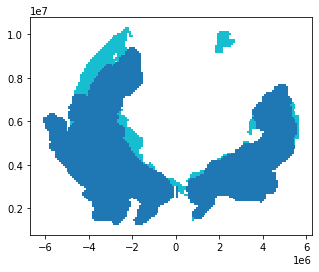

In [31]:
# Get all boreal tiles
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' #shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg
boreal_tile_index = gpd.read_file(boreal_tile_index_path)

bad_tiles = [3540,3634,3728,3823,3916,4004] #Dropping the tiles near antimeridian that reproject poorly.
if True:
    # Remove bad tiles
    boreal_tile_index = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]

boreal_tile_index.plot(column='tile_version')
boreal_tile_index.groupby('tile_version')['tile_group'].agg(['count'])

INPUT_TILE_NUM_LIST = boreal_tile_index[boreal_tile_index.tile_version == 'version 2'].tile_num.to_list()

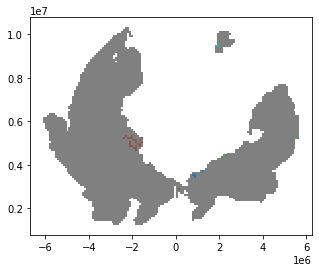

In [45]:
need_tile_index_path = '/projects/my-public-bucket/DPS_tile_lists/Need_Topo_tindex_master.gpkg'
need_tile_index = gpd.read_file(need_tile_index_path)

if True:
    # Remove bad tiles
    need_tile_index = need_tile_index[~need_tile_index['tile_num'].isin(bad_tiles)]

ax = boreal_tile_index.plot(color='gray')
need_tile_index[need_tile_index.tile_version == 'version 2'].plot(column='tile_group', ax=ax)

need_tile_index[need_tile_index.tile_version == 'version 2'].groupby('tile_version')['tile_group'].agg(['count'])

INPUT_TILE_NUM_LIST = need_tile_index[need_tile_index.tile_version == 'version 2'].tile_num.to_list()

In [36]:
 len(INPUT_TILE_NUM_LIST)

34

In [37]:
TEST_DPS  = False

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[0:100] #INPUT_TILE_NUM_LIST[100:]
else:
    print('Running DPS on the FULL list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on the FULL list of input
List length: 34


# Run a DPS of topo tiles

In [40]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = 'do_topo_stack_3-1-5'
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-8gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'tile_buffer_m': 120,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'topo_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/dem30m_tiles.geojson',
        }

    submit_result = maap.submitJob(
            identifier=IDENTIFIER,
            algo_id=ALGO_ID,
            version='master',
            username=USER, # username needs to be the same as whoever created the workspace
            queue=WORKER_TYPE,
            **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 100, 500, 1000, 1500, 2000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 34
DPS run #: 1	| tile num: 25513	| submit status: success	| job id: 72635831-6a39-4e0b-828e-04182a7562ad
DPS run #: 34	| tile num: 42371	| submit status: success	| job id: 42914ed5-d322-4fe8-ab16-3fc8630daba9
Current time:	202203211802
CPU times: user 369 ms, sys: 38.2 ms, total: 407 ms
Wall time: 7.68 s


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type
0,success,200,72635831-6a39-4e0b-828e-04182a7562ad,1,25513,2022-03-21 18:02:40.067684,18,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,success,200,ca80bad1-2943-4d90-aa98-06e354a888f1,2,29484,2022-03-21 18:02:40.220269,18,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,success,200,40aae9c3-ae19-45ce-af84-7f0511d02ade,3,36846,2022-03-21 18:02:40.316080,18,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,success,200,b023a965-7337-4c75-8414-ae4a2232c03e,4,36849,2022-03-21 18:02:40.417610,18,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,success,200,843bec48-2301-47cb-81be-e37ed5485079,5,37071,2022-03-21 18:02:40.608673,18,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,success,200,d75a1915-12cb-4b3b-a991-ce995af748b4,6,37073,2022-03-21 18:02:40.757814,18,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,success,200,2244e2b1-0341-4514-931f-88a1fa69f599,7,37074,2022-03-21 18:02:40.935130,18,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,success,200,f4e14450-654e-4396-b7f4-a04ee0ba8517,8,37075,2022-03-21 18:02:41.159977,18,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,success,200,10972518-1646-4686-9449-de3d0719c2be,9,37080,2022-03-21 18:02:41.391935,18,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,success,200,da9547c5-b36a-4920-ac6a-926d908e99e8,10,37143,2022-03-21 18:02:41.607515,18,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [49]:
%%time
def BUILD_TABLE_JOBSTATUS(submit_results_df):
    import xmltodict
    df = pd.concat([pd.DataFrame(xmltodict.parse(maap.getJobStatus(job_id).content)).transpose() for job_id in submit_results_df.job_id.to_list()])
    return df

job_status_df = BUILD_TABLE_JOBSTATUS(submit_results_df)
#print(job_status_df.head())

num_jobs = submit_results_df.shape[0]
z = submit_results_df.merge(job_status_df, how='left', left_on='job_id',  right_on='wps:JobID')

print(f'Count total jobs:\t{num_jobs}')
print(f"Count pending jobs:\t{z[z['wps:Status'] =='Accepted'].shape[0]}")
print(f"Count running jobs:\t{z[z['wps:Status'] =='Running'].shape[0]}")
print(f"Count succeeded jobs:\t{z[z['wps:Status'] =='Succeeded'].shape[0]}")
print(f"Count failed jobs:\t{z[z['wps:Status'] =='Failed'].shape[0]}")
print(f"% of failed jobs:\t{round(z[z['wps:Status'] =='Failed'].shape[0] / ( z[z['wps:Status'] =='Failed'].shape[0] + z[z['wps:Status'] =='Succeeded'].shape[0] ), 4) * 100}")

Count total jobs:	34
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	34
Count failed jobs:	0
% of failed jobs:	0.0
CPU times: user 364 ms, sys: 18.3 ms, total: 383 ms
Wall time: 999 ms


In [103]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Succeeded'].iloc[-1].job_id).content)

OrderedDict([('wps:Result',
              OrderedDict([('@xmlns:ows', 'http://www.opengis.net/ows/2.0'),
                           ('@xmlns:schemaLocation',
                            'http://schemas.opengis.net/wps/2.0/wps.xsd'),
                           ('@xmlns:wps', 'http://www.opengis.net/wps/2.0'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('wps:JobID',
                            'e67c048f-8f48-4be6-a7d1-66a4f1271237'),
                           ('wps:Output',
                            OrderedDict([('@id',
                                          'output-2022-03-21T14:01:34.913522'),
                                         ('wps:Data',
                                          ['http://maap-ops-workspace.s3-website-us-west-2.amazonaws.com/nathanmthomas/dps_output/do_topo_stack_3-1-5_ubuntu/master/2022/03/21/14/01/34/913522',
                                           's3

In [67]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Failed'].iloc[0].job_id).content)

OrderedDict([('wps:Result',
              OrderedDict([('@xmlns:ows', 'http://www.opengis.net/ows/2.0'),
                           ('@xmlns:schemaLocation',
                            'http://schemas.opengis.net/wps/2.0/wps.xsd'),
                           ('@xmlns:wps', 'http://www.opengis.net/wps/2.0'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('wps:JobID',
                            'bb33d840-9e34-4c20-b786-04e94d4103af'),
                           ('wps:Output',
                            OrderedDict([('@id', 'traceback'),
                                         ('wps:Data',
                                          'activate does not accept more than one argument:\n[\'/app/icesat2_boreal/dps/alg_3-1-5/run.sh\', \'24620\', \'120\', \'boreal_tiles_v003\']\n\n+ /app/icesat2_boreal/dps/alg_3-1-5/run.sh 24620 120 boreal_tiles_v003\n+ unset PROJ_LIB\n+ mkdir output\n+++ dirname /

### Update the tile index master csv

In [50]:
MAAP_VERSION = 'master'
OUTDIR = f'/projects/my-public-bucket/Topo/{MAAP_VERSION}'
!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t Topo -y 2022 -m 03 -o $OUTDIR --maap_version $MAAP_VERSION
MAAP_VERSION = 'ops'
OUTDIR = f'/projects/my-public-bucket/Topo/{MAAP_VERSION}'
#!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t Topo -y 2021 -m '*' -o $OUTDIR --maap_version $MAAP_VERSION

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		Topo
Year:		2022
Month:		03
Days:		1-31

Output dir:  /projects/my-public-bucket/Topo/master
                                             s3_path  ...                                        file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  Copernicus_23548_covars_cog_topo_stack.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  Copernicus_23547_covars_cog_topo_stack.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  Copernicus_23549_covars_cog_topo_stack.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  Copernicus_23550_covars_cog_topo_stack.tif
4  s3://maap-ops-workspace/nathanmthom

# Combine Topo tindex master csvs from 'ops' and 'master', remove dups, and save to final list

In [51]:
out_tindex_fn = '/projects/my-public-bucket/DPS_tile_lists/Topo_tindex_master.csv'
fn_list = ['/projects/my-public-bucket/Topo/master/Topo_tindex_master.csv', '/projects/my-public-bucket/Topo/ops/Topo_tindex_master.csv']
df = pd.concat([pd.read_csv(fn) for fn in fn_list])
len(df)
duplicate_tiles = [item for item, count in collections.Counter(df["tile_num"]).items() if count > 1]
print(duplicate_tiles)
print(len(df))
df.to_csv(out_tindex_fn)
df.head()

[]
5072


,Unnamed: 0,s3_path,local_path,file,tile_num
0,26,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_topo...,Copernicus_24109_covars_cog_topo_stack.tif,24109
1,89,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_topo...,Copernicus_23551_covars_cog_topo_stack.tif,23551
2,90,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_topo...,Copernicus_23550_covars_cog_topo_stack.tif,23550
3,91,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_topo...,Copernicus_23833_covars_cog_topo_stack.tif,23833
4,92,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_topo...,Copernicus_23219_covars_cog_topo_stack.tif,23219
